# Tutorial 12: DOGMA-seq (PBMC)

DOGMA-seq enables simultaneous analysis of chromatin accessibility, gene expression, and surface proteins within individual cells. DePass was applied to the human PBMC DOGMA-seq dataset (13,763 cells) for cross-modal integration. This tutorial demonstrates clustering and dimensionality reduction (UMAP) visualization.

### Preparation

In [ ]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'

path = '../data/dataset_DOGMAseq'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '/home/jyx/DePass-main/outputs/dataset_DOGMAseq/run for' already exists.



### Loading and Preprocessing

In [ ]:
adata_omics1 = sc.read_h5ad('../data/dataset_DOGMAseq/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_DOGMAseq/adata_ATAC.h5ad')
adata_omics3 = sc.read_h5ad('../data/dataset_DOGMAseq/adata_ADT.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='atac')
preprocess_data(adata=adata_omics3,modality='protein')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_lsi'].copy()
adata_omics3.obsm['input_feat'] = adata_omics3.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'atac': adata_omics2,'protein': adata_omics3}

### Training the model

In [ ]:
from DePass.model import DePass
model = DePass(data, data_type='single_cell',device=device)
model.train()

[Config]
Modalities: 3 | Data: single_cell | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:25<00:00,  7.79it/s]


Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding

### Clustering

In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=27,key='DePass',add_key='DePass',method='mclust',use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [ ]:
from DePass.utils import super_eval
import pandas as pd
re = super_eval(adata.obs['DePass'],adata.obs['Y'])
pd.DataFrame(list(re.items()), columns=['metric', 'Value']).to_csv(path + '/re.csv', sep='\t', index=True, float_format='%.6f')
print(re)

{'AMI': 0.5262018356211751, 'NMI': 0.5304512934724694, 'ARI': 0.31539009360092624, 'Homogeneity': 0.6327088207802715, 'V-measure': 0.5304512934724694, 'Mutual Information': 1.3936840065103853}


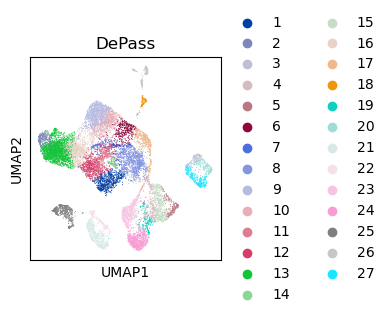

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))  

sc.pp.neighbors(adata, use_rep='DePass', n_neighbors=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='DePass', title='DePass', ax=ax, s=2, show=False)

plt.tight_layout()
plt.savefig(path +  '/DePass.pdf', bbox_inches='tight', dpi=300)
plt.show()

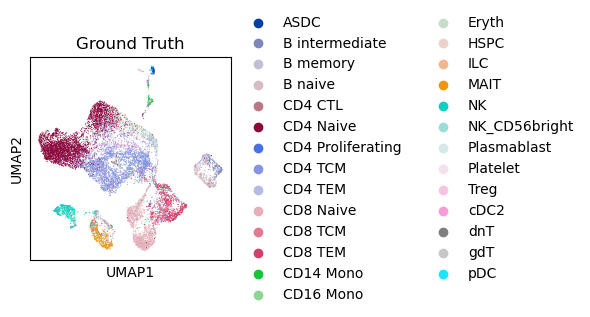

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))  

sc.pl.umap(adata, color='celltype', title='Ground Truth', s=2, ax = ax ,show=False)
plt.tight_layout()
plt.savefig(path +  '/Ground Truth.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
adata.write(path+'/adata.h5ad')